In [22]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, roc_curve, confusion_matrix, f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
import pickle

In [23]:
matrix = pd.read_csv('/home/jsearle/bigDrive/NAX/NLP-SAH_identification/finalModel/2_full_matrix.csv', index_col=0)
y_data = matrix[['BDSPPatientID', 'NoteTitle', 'annot']]
X_holdout = matrix.drop(columns=['BDSPPatientID', 'NoteDate', 'NoteTitle', 'text', 'hospital', 'annot'])
X_holdout.head()

,ICD,headach,doubl vision,diplopia,sudden,neck pain,nausea,vomit,dizzi,photophobia,...,neg_am,neg_ivh,neg_parenchym hemorrhag,neg_intraventricular hemorrhag,neg_subdur,neg_tbi,neg_traumat brain injuri,neg_neuro icu,neg_confus,neg_syncop
0,1,1,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,1,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [24]:
y_holdout = y_data['annot']
y_holdout.head()

0    1
1    0
2    1
3    1
4    0
Name: annot, dtype: int64

In [25]:
y_pred_proba = 0
y_pred = 0
false_positives = []
false_negatives = []

for fold in range(10):
    model_filename = f'/home/jsearle/bigDrive/NAX/NLP-SAH_identification/trainModels/results/LogReg/models/model_train_allhospitals_Notes+ICD_fold{fold+1}.pickle'  # Updated path
    with open(model_filename, 'rb') as f:
        res = pickle.load(f)
    model = res['model']
    cutoff = res['cutoff']
    yp =  model.predict_proba(X_holdout)[:, 1]
    # for probability output, we take average as the final probability
    y_pred_proba += yp
    # for binary output (yes/no), we binarize within each fold, and then take majority vote across folds to get final binary output
    y_pred += (yp>cutoff).astype(int)

# Average the probabilities and get binary predictions
y_pred_proba /= 10
y_pred_bin = (y_pred>5).astype(int)

# Calculate metrics
fpr, tpr, cutoffs = roc_curve(y_holdout, y_pred_proba)
auc_holdout=roc_auc_score(y_holdout, y_pred_proba)
f1_holdout=f1_score(y_holdout, y_pred_bin)
precision_holdout=precision_score(y_holdout, y_pred_bin)
recall_holdout=recall_score(y_holdout, y_pred_bin)
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_proba)
auc_pr = auc(recall, precision)
# auc_pr_holdout.append(auc_pr)
cf_holdout=confusion_matrix(y_holdout, y_pred_bin)
holdout_predictions=y_pred_bin
roc_curves_holdout=(fpr, tpr, roc_auc_score(y_holdout, y_pred_proba))
pr_curves_holdout=(recall, precision, auc_pr)

# Identify false positives and false negatives
false_positive_ids = y_data['BDSPPatientID'][(y_holdout == 0) & (y_pred_bin == 1)]
false_negative_ids = y_data['BDSPPatientID'][(y_holdout == 1) & (y_pred_bin == 0)]
false_positives.append(false_positive_ids)
false_negatives.append(false_negative_ids)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- hyperten
- multi compart
- neg_accid
- neg_acom
- neg_atraumat
- ...
Feature names seen at fit time, yet now missing:
- hypertens
- multi compartment
- neg_hypertens
- neg_neurosurg intervent
- neg_normocephal
- ...


In [7]:
print(np.mean(auc_cv))
print(np.mean(auc_pr))


0.9850306460456212
0.9615786935375304


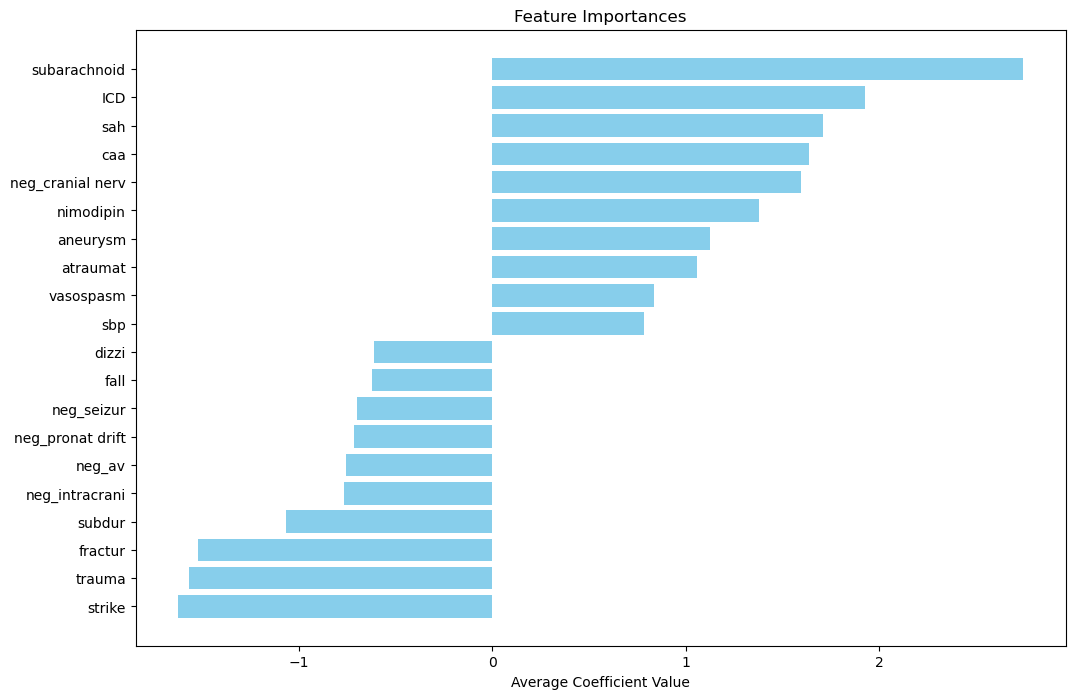

In [8]:
# Aggregate feature importances by averaging over folds
avg_feature_importances = {feature: np.mean(importances) for feature, importances in feature_importances_dict.items()}
sorted_features = sorted(avg_feature_importances.items(), key=lambda item: item[1], reverse=True)
features, importances = zip(*sorted_features)

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Define the output directory
output_dir = '/home/jsearle/bigDrive/NAX/NLP-SAH_identification/finalModel/results/LogReg'

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the DataFrame to a CSV file
csv_file_path = os.path.join(output_dir, 'feat_importances.csv')
feature_importance_df.to_csv(csv_file_path, index=False)

# Select top 10 and bottom 10 features
top_features = features[:10]
top_importances = importances[:10]
bottom_features = features[-10:]
bottom_importances = importances[-10:]

# Combine top and bottom features for plotting
plot_features = top_features + bottom_features
plot_importances = top_importances + bottom_importances

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(plot_features, plot_importances, color='skyblue')
plt.xlabel('Average Coefficient Value')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top

# Save the plot to a PNG file
plt.savefig(os.path.join(output_dir, 'feat_importances.png'))
plt.show()



In [9]:
# Initialize lists to store false positives and false negatives
false_positives = []
false_negatives = []

# Iterate through the combined lists
for pred, true, pid in zip(all_predictions, all_true_labels, all_row_numbers):
    if pred == 1 and true == 0:
        false_positives.append(pid)
    elif pred == 0 and true == 1:
        false_negatives.append(pid)

# Convert the lists to DataFrames for easier access and analysis
false_positives_df = pd.DataFrame(false_positives, columns=['BDSPPatientID'])
false_negatives_df = pd.DataFrame(false_negatives, columns=['BDSPPatientID'])

# Save the DataFrames to CSV files
FP_file_path = os.path.join(output_dir, 'false_positives.csv')
FN_file_path = os.path.join(output_dir, 'false_negatives.csv')
false_positives_df.to_csv(FP_file_path, index=False)
false_negatives_df.to_csv(FN_file_path, index=False)

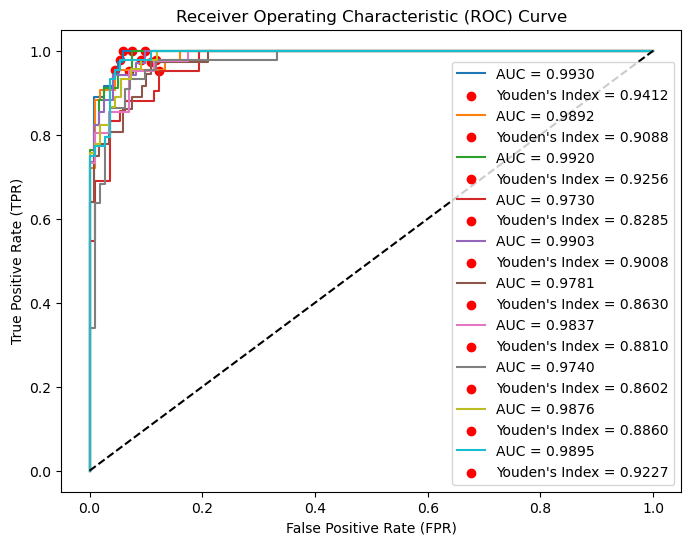

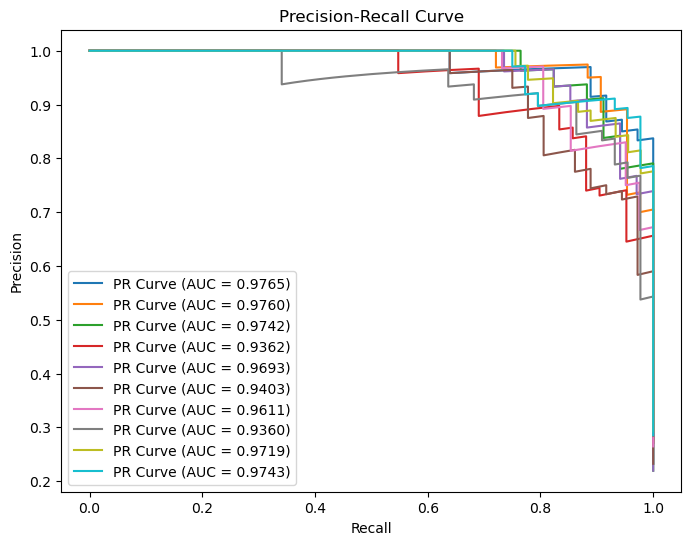

0.9850306460456212
0.8748360501556016


In [10]:
# Plot all ROC curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for fpr, tpr, auc_score in roc_curves:
    plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(auc_score))
    youden = np.max(tpr-fpr)
    plt.scatter(fpr[np.argmax(tpr-fpr)], tpr[np.argmax(tpr-fpr)], c='red', label=f'Youden\'s Index = {youden:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random classifier
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(os.path.join(output_dir, 'AUC_iter.png'))
plt.show()

# Plot all PR curves overlayed on a single graph
plt.figure(figsize=(8, 6))
for recall, precision, auc_pr_loop in pr_curves:
    plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(auc_pr_loop))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.savefig(os.path.join(output_dir, 'PR_iter.png'))
plt.show()


# Create a DataFrame to hold the results
results_df = pd.DataFrame({'Unnamed: 0': all_row_numbers, 'annot': all_true_labels, 'prediction': all_predictions})

# Save the DataFrame to a CSV file
results_df.to_csv(os.path.join(output_dir, 'LR_iter_pred_rr.csv'), index=False)

# Calculate the final AUC and F1
auc_final = np.mean(auc_cv)
f1_final = np.mean(f1_cv)

# Save all the data
df = pd.DataFrame()
df['auc'] = auc_cv
df['f1s'] = f1_cv
df['auc_pr'] = auc_pr
df['C'] = final_Cs
df['l1_ratio'] = final_l1
df_pred = pd.DataFrame()
df1 = pd.DataFrame(predictions[0])
df2 = pd.DataFrame(predictions[1])
df3 = pd.DataFrame(predictions[2])
df4 = pd.DataFrame(predictions[3])
df5 = pd.DataFrame(predictions[4])
df_pred = pd.concat([df1,df2,df3,df4,df5]).reset_index()
df.to_csv(os.path.join(output_dir, 'LR_iter.csv'))

# Print final Data
print(auc_final)
print(f1_final)

In [11]:
print(final_Cs)
print(final_l1)

[0.649421031735167, 0.5988026514545343, 0.6808292380964068, 0.6518945342329485, 0.3617758687035124, 0.6468904124539905, 0.5196985800405489, 0.7458808297159538, 0.5615226258355744, 0.7670982459039197]
[0.99, 0.9189500642743518, 0.9482672379871021, 0.9825114426491014, 0.36821025838313887, 0.972554261168853, 0.8875747388460428, 0.7919524840237818, 0.9612336277011012, 0.8623387582007134]


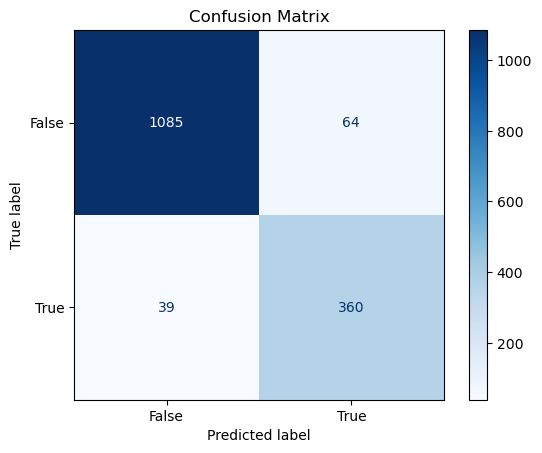

[[1085   64]
 [  39  360]]


In [12]:
# Create the confusion matrix
cf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=[False, True])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(os.path.join(output_dir, 'cf_matrix.png'))
plt.show()

# Print the confusion matrix
print(cf_matrix)

In [13]:
def calculate_metrics(cf_matrix):
    TN, FP, FN, TP = cf_matrix.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, precision, recall, f1
# Calculate metrics for each fold
for fold_index, cf_matrix in enumerate(cf_cv):
    accuracy, precision, recall, f1 = calculate_metrics(cf_matrix)
    print(f"Metrics for Fold {fold_index + 1}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")
# Calculate overall metrics
overall_cf_matrix = np.sum(cf_cv, axis=0)
overall_accuracy, overall_precision, overall_recall, overall_f1 = calculate_metrics(overall_cf_matrix)
print("Overall Metrics:")
print(f"Accuracy: {overall_accuracy:.4f}")
print(f"Precision: {overall_precision:.4f}")
print(f"Recall: {overall_recall:.4f}")
print(f"F1 Score: {overall_f1:.4f}")

Metrics for Fold 1:
Accuracy: 0.9548
Precision: 0.8718
Recall: 0.9444
F1 Score: 0.9067

Metrics for Fold 2:
Accuracy: 0.9290
Precision: 0.8200
Recall: 0.9535
F1 Score: 0.8817

Metrics for Fold 3:
Accuracy: 0.9548
Precision: 0.8857
Recall: 0.9118
F1 Score: 0.8986

Metrics for Fold 4:
Accuracy: 0.9290
Precision: 0.8974
Recall: 0.8333
F1 Score: 0.8642

Metrics for Fold 5:
Accuracy: 0.9419
Precision: 0.8205
Recall: 0.9412
F1 Score: 0.8767

Metrics for Fold 6:
Accuracy: 0.9097
Precision: 0.7619
Recall: 0.8889
F1 Score: 0.8205

Metrics for Fold 7:
Accuracy: 0.9097
Precision: 0.8140
Recall: 0.8537
F1 Score: 0.8333

Metrics for Fold 8:
Accuracy: 0.9226
Precision: 0.8478
Recall: 0.8864
F1 Score: 0.8667

Metrics for Fold 9:
Accuracy: 0.9351
Precision: 0.8889
Recall: 0.8889
F1 Score: 0.8889

Metrics for Fold 10:
Accuracy: 0.9481
Precision: 0.8913
Recall: 0.9318
F1 Score: 0.9111

Overall Metrics:
Accuracy: 0.9335
Precision: 0.8491
Recall: 0.9023
F1 Score: 0.8748
